In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

# 1. Data Preparation

In [2]:
# Importing the CSV
df_initial = pd.read_csv('Telco_Customer_Churn.csv')
df_initial.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Converting Total Charges to a numerical data type and check for Null entries
df_initial.TotalCharges = pd.to_numeric(df_initial.TotalCharges, errors='coerce')
df_initial.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

From the output above, there are 11 missing values for TotalCharges. I will be removing those 11 entries from the dataset.

In [4]:
# Removing the 11 missing entries 
df_initial.dropna(inplace = True)

# Remove customer ID from dataset
df = df_initial.iloc[:,1:]

# Convert predictor variable (Churn) into a binary (1/0) numeric variable
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

# Convert all the categorical variables into dummy variables
df_dummy = pd.get_dummies(df, dtype=int)
df_dummy.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


<Axes: >

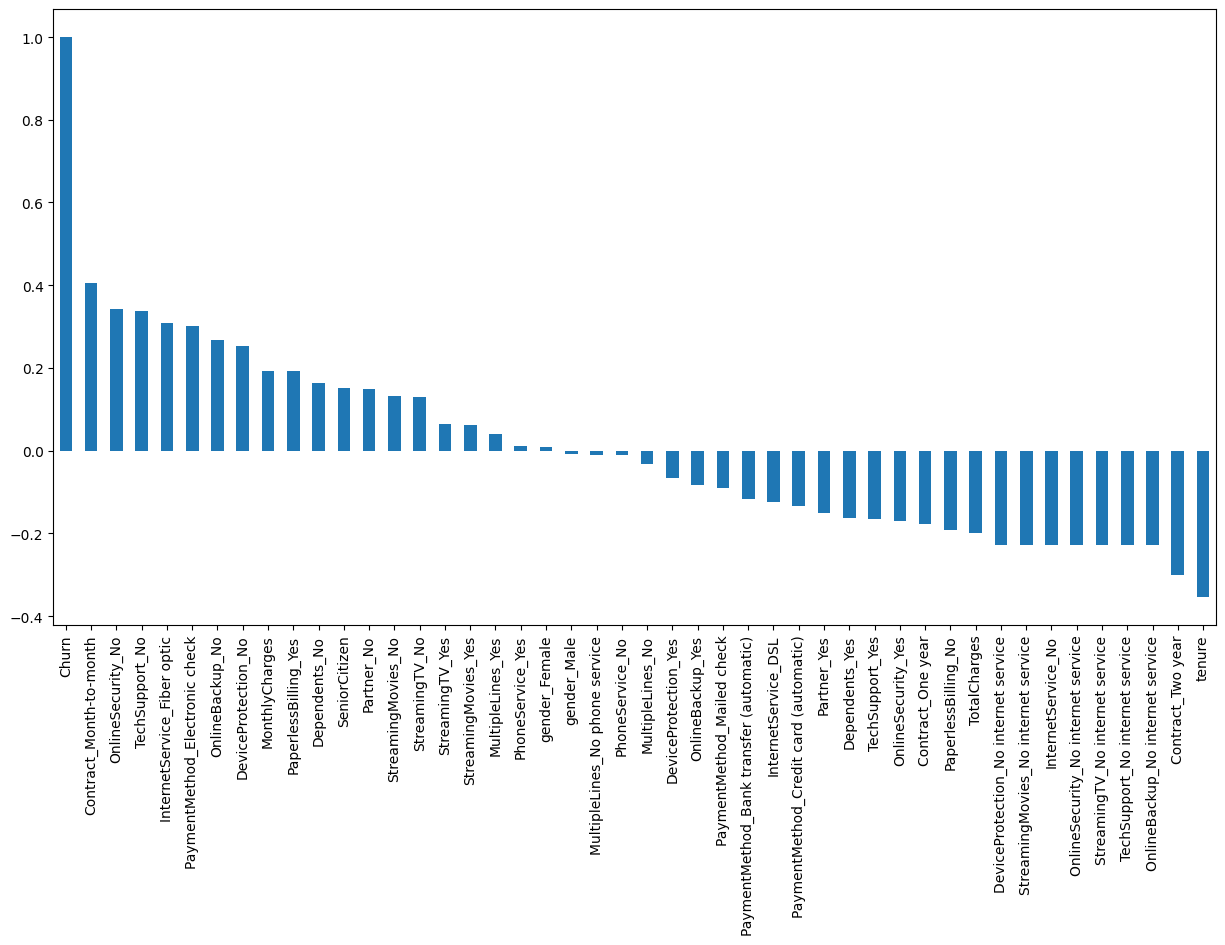

In [5]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df_dummy.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

Referring to the Correlation of Churn with other variables above, the following are the most notable for further investigation:

**Positively Correlated to Churn (Customers with these qualities are more likely to churn):**
1) Contract_Month-to-month
2) OnlineSecurity_No
3) TechSupport_No

**Negatively Correlated to Churn (Customers with these qualities are less likely to churn):**
1) Tenure (Subscribed to this Telco for longer)
2) Contract_Two year
3) InternetService_No

In [6]:
# Downsampling using majority class method

# Split the DataFrame into majority and minority classes
df_majority = df_dummy[df_dummy.Churn == 0]
df_minority = df_dummy[df_dummy.Churn == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # match minority class
                                   random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the DataFrame
df_downsampled = df_downsampled.sample(frac=1, random_state=123).reset_index(drop=True)

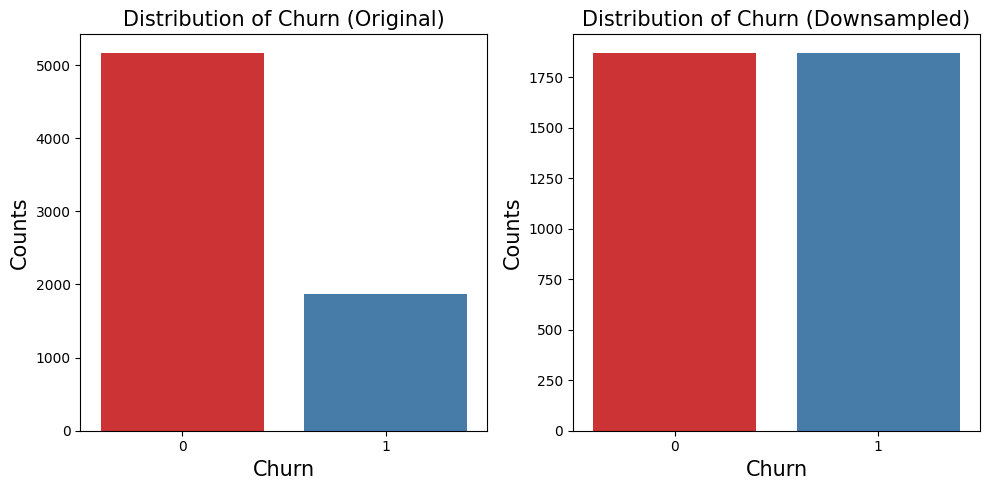

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  # Total figure size for both plots

# Graph 1: Distribution of churn for the original dataset
churn_cnt = df.Churn.value_counts()
sns.barplot(x=churn_cnt.index, y=churn_cnt.values, ax=axes[0], hue=churn_cnt.index, palette='Set1', legend=False)  # Set hue and legend=False

axes[0].set_xlabel("Churn", fontsize=15)
axes[0].set_ylabel("Counts", fontsize=15)
axes[0].set_title("Distribution of Churn (Original)", fontsize=15)

# Graph 2: Distribution of churn for the downsampled dataset
churn_cnt_downsampled = df_downsampled.Churn.value_counts()
sns.barplot(x=churn_cnt_downsampled.index, y=churn_cnt_downsampled.values, ax=axes[1], hue=churn_cnt_downsampled.index, palette='Set1', legend=False)

axes[1].set_xlabel("Churn", fontsize=15)
axes[1].set_ylabel("Counts", fontsize=15)
axes[1].set_title("Distribution of Churn (Downsampled)", fontsize=15)

plt.tight_layout()  # Adjusts subplots to fit in the figure area
plt.show()

As seen above, I have successfully downsampled the data such that the amount of Churn (0 and 1) are now equal at 1869 entries each, meaning the dataset is much less biased.

# 2. Logistic Regression

Logistic Regression is a statistical method that helps predict the probability of an event happening. It analyzes data to identify relationships between different factors and then uses those relationships to estimate how likely something is to occur. For instance, it could be used to predict if a customer will churn (cancel their service) or whether an email is spam.

Unlike regular regression, which predicts continuous values, logistic regression focuses on binary outcomes (yes/no, 0/1). It does this by employing a mathematical function called the sigmoid function (also known as the logistic function) to transform the results into probabilities between 0 and 1.

In [8]:
# Mapping the X and Y axis
y = df_downsampled['Churn'].values
X = df_downsampled.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [9]:
# Create Train & Test Data by splitting at ratio of 75% and 25% respectively
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [10]:
# Fitting the model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
result = model.fit(X_train, y_train)

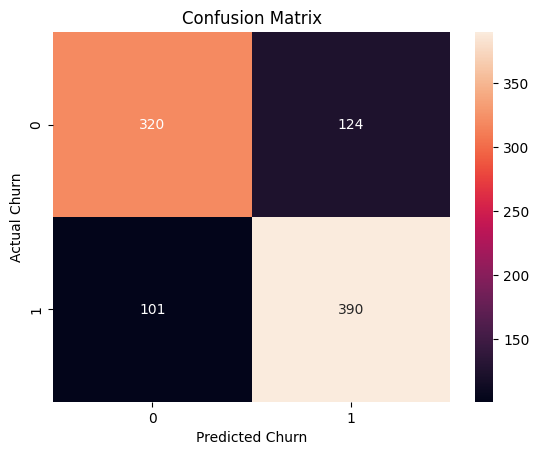

In [11]:
# Plotting Confusion Matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Plot using Seaborn
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.show()

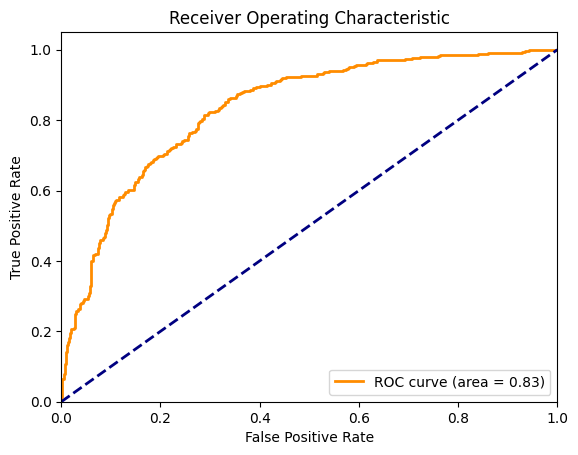

In [12]:
y_pred_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\nLog Loss: {logloss}\nROC AUC: {roc_auc}")

Accuracy: 0.7593582887700535
Precision: 0.7587548638132295
Recall: 0.7942973523421588
F1 Score: 0.7761194029850746
Log Loss: 0.5052839502019649
ROC AUC: 0.8339525880259078


**Accuracy (~0.78):** This is the proportion of true results (both true positives and true negatives) among the total number of cases examined. An accuracy of approximately 77% means that the model correctly predicts the outcome 77% of the time, which is generally good.

**Precision (~0.78):** Precision is the ratio of true positives to the sum of true and false positives. It indicates the quality of the positive class predictions. A precision of 77% means that when the model predicts the positive class, it is correct about two-thirds of the time. This is decent but suggests some room for improvement in reducing false positives.

**Recall (~0.8):** Recall, or sensitivity, measures the proportion of actual positives that are correctly identified. A recall of 80% means the model identifies 80% of all actual positive cases.

**F1 Score (~0.79):** The F1 score is the harmonic mean of precision and recall, providing a single metric to assess the balance between them. An F1 score of 60% is moderate, indicating that there is a balance but also room for improvement in both precision and recall.

**Log Loss (~0.48):** Log loss measures the performance of a classification model where the prediction is a probability value between 0 and 1. A lower log loss indicates a better model. A log loss of about 0.48 means that, on average, the model's probability estimates are fairly well-calibrated.

**ROC AUC (~0.85):** The Area Under the Receiver Operating Characteristic Curve (ROC AUC) measures the ability of a model to distinguish between classes. An AUC of 0.85 is quite good, indicating a high level of separability, meaning the model is well capable of distinguishing between the positive and negative classes.

**Conclusion**
These values suggest that the model performs reasonably well in general terms. It has a high ROC AUC score, suggesting good discriminative ability, and a fair balance between precision and recall as reflected in the F1 score. The accuracy is also relatively high. The log loss indicates how closely the probability predictions of the model match the actual outcomes.

## 2.1 Further Analysis of Logistic Regression Model

I will be printing the top 10 most positive and negative weights of the Logistic Regression model below.

This is to visualize the top 10 most influential features in the model according to their coefficients. High positive values indicate a feature that increases the likelihood of Churn, whereas high negative values indicate a feature that decreases the likelihood of Churn.

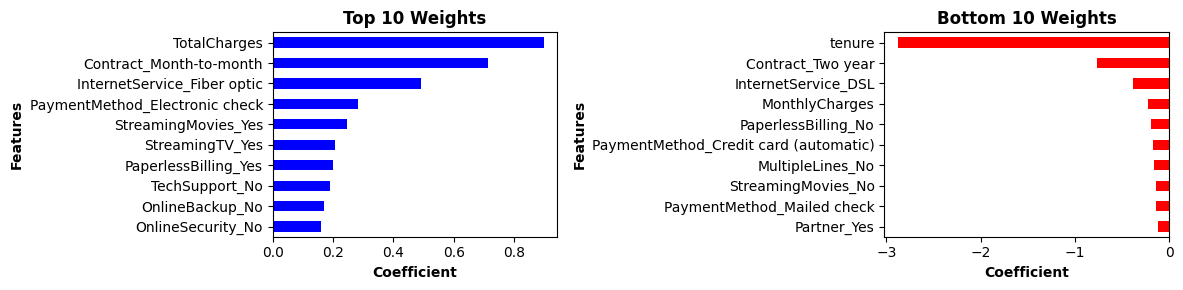

In [14]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0], index=X.columns.values)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
# Plot the top 10 weights
weights.sort_values(ascending=True)[-10:].plot(kind='barh', ax=ax[0], color='blue')
ax[0].set_title('Top 10 Weights', fontweight='bold')
ax[0].set_xlabel('Coefficient', fontweight='bold')
ax[0].set_ylabel('Features', fontweight='bold')

# Plot the bottom 10 weights
weights.sort_values(ascending=False)[-10:].plot(kind='barh', ax=ax[1], color='red')
ax[1].set_title('Bottom 10 Weights', fontweight='bold')
ax[1].set_xlabel('Coefficient', fontweight='bold')
ax[1].set_ylabel('Features', fontweight='bold')

plt.tight_layout()
plt.show()

The top 3 postive and negative weights based on the Logistic Regression model are as follow:

**Top 3 Most Positive Weights:**
1) TotalCharges
2) <mark>Contract_Month-to-month<mark>
3) InternetService_Fiber optic

**Top 3 Most Negative Weights:**
1) <mark>Tenure<mark>
2) <mark>Contract_Two year<mark>
3) InternetService_DSL
-----------------------------------------------------------
Correlation Index against Churn (From Initial Analysis):

**Positively Correlated to Churn (Customers with these qualities are more likely to churn):**
1) <mark>Contract_Month-to-month<mark>
2) OnlineSecurity_No
3) TechSupport_No

**Negatively Correlated to Churn (Customers with these qualities are less likely to churn):**
1) <mark>Tenure (Subscribed to this Telco for longer)<mark>
2) <mark>Contract_Two year<mark>
3) InternetService_No

We can infer from the highlighted categories that they are very important in predicting whether a customer will churn or not. Hence, it may be relevant for the telco to look into pre-existing policies and plans they have in place to further investigate their customer churn rate.

# 3. K-Nearest Neighbours

We will compare the Logistic Regression's accuracy against other Machine Learning Models.

K-Nearest Neighbors (KNN) is a simple and versatile supervised machine learning algorithm for both classification and regression. Each feature in the input data represents one dimension in an n-dimensional feature space.

When a new (test) data point needs to be classified, KNN calculates the distance from this new point to all other points in the training dataset. After calculating the distances, the algorithm sorts these distances and determines the nearest 'k' data points — these are the 'K-Nearest Neighbors'.

In [15]:
# Importing K-Nearest Neighbours model
from sklearn.neighbors import KNeighborsClassifier

In [16]:
# Fitting the model
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

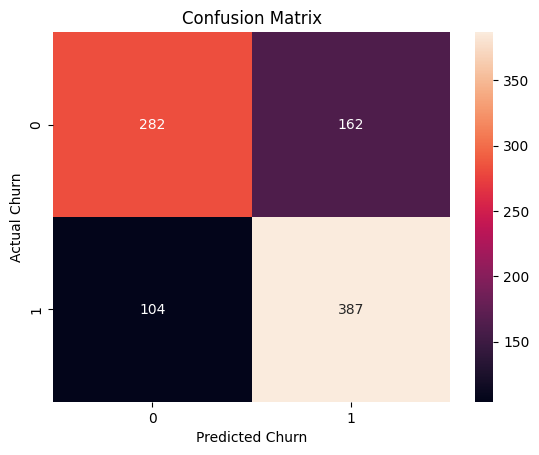

In [17]:
cm = confusion_matrix(y_test, y_pred_knn)

# Plot using Seaborn
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.show()

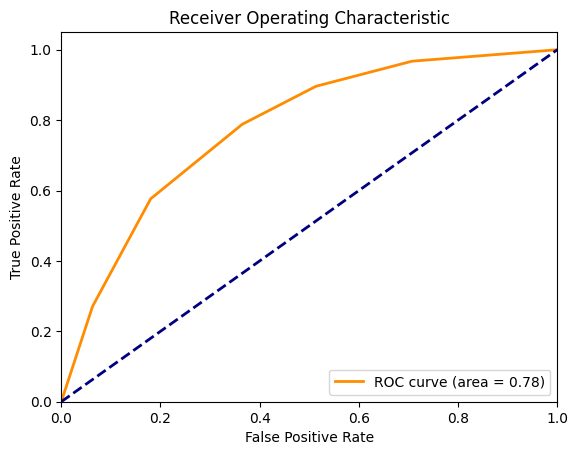

In [18]:
y_pred_knn_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [19]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
logloss_knn = log_loss(y_test, y_pred_knn_prob)
roc_auc_knn = roc_auc_score(y_test, y_pred_knn_prob)

print(f"Accuracy: {accuracy_knn}\nPrecision: {precision_knn}\nRecall: {recall_knn}\nF1 Score: {f1_knn}\nLog Loss: {logloss_knn}\nROC AUC: {roc_auc_knn}")

Accuracy: 0.7155080213903743
Precision: 0.7049180327868853
Recall: 0.7881873727087576
F1 Score: 0.7442307692307694
Log Loss: 2.1274260218784002
ROC AUC: 0.7778481128786627


# 4. Random Forest

Random Forest is an ensemble machine learning algorithm that combines multiple decision trees to improve prediction accuracy and avoid overfitting. It is used for both classification and regression tasks.

Random Forest leverages the power of multiple decision trees (an "ensemble"), which are trained on different parts of the same training set. By averaging the predictions of these trees or using a majority voting system, it produces a more accurate and stable prediction than any individual tree could.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [21]:
# Fitting the model
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "sqrt",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = model_rf.predict(X_test)

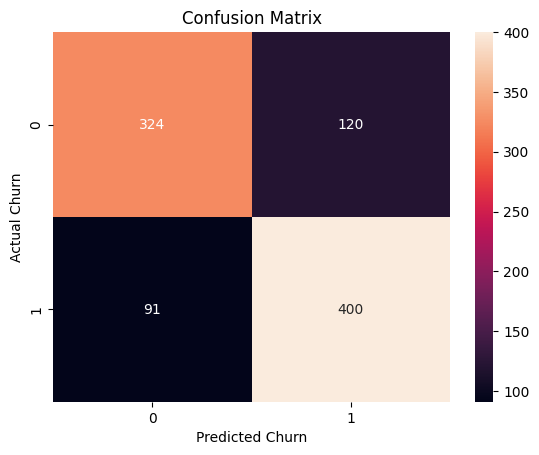

In [22]:
cm = confusion_matrix(y_test, y_pred_rf)

# Plot using Seaborn
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Churn')
plt.ylabel('Actual Churn')
plt.show()

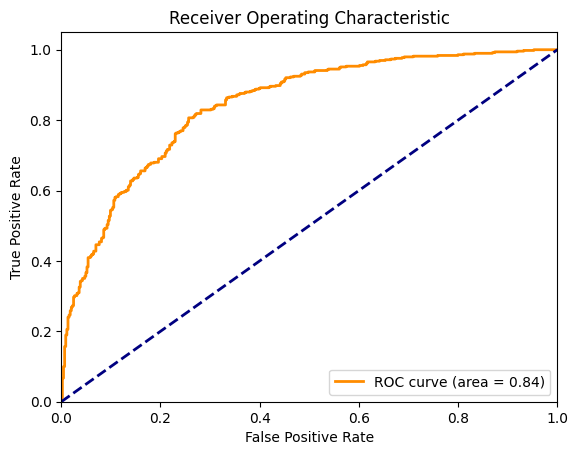

In [23]:
y_pred_rf_prob = model_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
logloss_rf = log_loss(y_test, y_pred_rf_prob)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

print(f"Accuracy: {accuracy_rf}\nPrecision: {precision_rf}\nRecall: {recall_rf}\nF1 Score: {f1_rf}\nLog Loss: {logloss_rf}\nROC AUC: {roc_auc_rf}")

Accuracy: 0.774331550802139
Precision: 0.7692307692307693
Recall: 0.814663951120163
F1 Score: 0.7912957467853612
Log Loss: 0.49762968802004315
ROC AUC: 0.8421450982550779


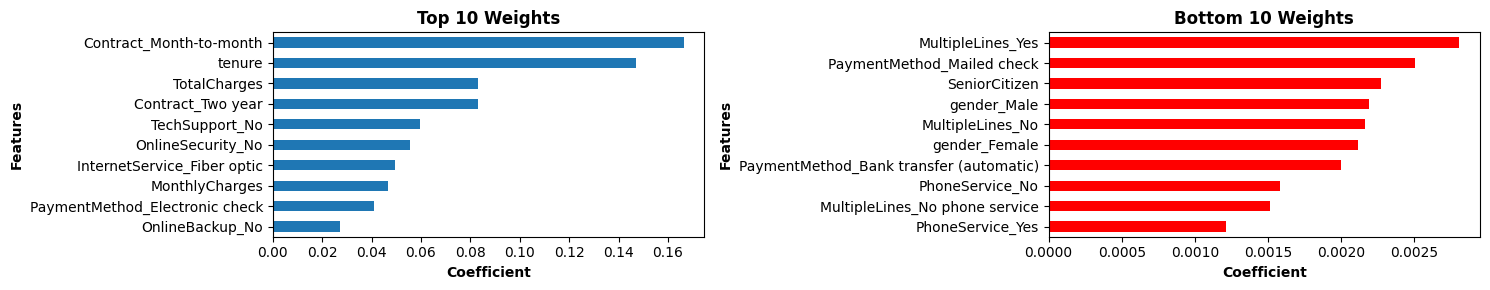

In [27]:
# Get feature importances
importances = model_rf.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame(importances, index=X_train.columns, columns=['Importance'])

# Setup the subplot grid
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

# Sort the importances for plotting
sorted_importances = feature_importances.sort_values(by='Importance', ascending=True)

sorted_importances.tail(10).plot(kind='barh', ax=ax[0], legend=False)
ax[0].set_title('Top 10 Weights', fontweight='bold')
ax[0].set_xlabel('Coefficient', fontweight='bold')
ax[0].set_ylabel('Features', fontweight='bold')

sorted_importances.head(10).plot(kind='barh', ax=ax[1], legend=False, color='red')
ax[1].set_title('Bottom 10 Weights', fontweight='bold')
ax[1].set_xlabel('Coefficient', fontweight='bold')
ax[1].set_ylabel('Features', fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Comparing the 3 Machine Learning Models

Taking each model's accuracy metrics (Accuracy, Precision, Recall, F1 Score, Log Loss, ROC AUC) into consideration, `K-Nearest Neighbours` is the worst performing model out of the 3.

`Logistic Regression` is slightly better than Random Forest with better accuracy metrics score overall. Hence, `Logistic Regression` may be an effective model to help the telco company in predicting future customer churn based on existing data.

Also, the Top & Bottom 3 weights identified by the `Logistic Regression` Model will be useful for the telco company to understand the profile of customers who churn. 

**Top 3 Most Positive Weights:**
1) TotalCharges
2) Contract_Month-to-month
3) InternetService_Fiber optic

**Top 3 Most Negative Weights:**
1) Tenure
2) Contract_Two year
3) InternetService_DSL